# Introduction

Compare three different architectures models for classifying waste images from the TrashNet dataset.
- Fully Connected Networks (FC),
- Convolutional Neural Networks (CNN)
- Quantum Convolutional Neural Networks (QCNN)

Then, evaluate the models classification:
- Accuracy
- Precision
- Recall
- F1-score
- Computational Efficiency
- Robustness

---

## 1. Import necessary libraries

In [ ]:
!pip install -U datasets

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from datasets import load_dataset

## 2. Load the TrashNet dataset

In [28]:
ds = load_dataset("garythung/trashnet")
print(ds)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 5054
    })
})


In [29]:
# Check the available splits in the dataset
print(ds.keys())

dict_keys(['train'])


## 3. Image and label preprocessing

In [37]:
def preprocess_image(image):
    image = image.resize((64, 64))
    image = np.array(image)
    return image

processed_dataset = ds.map(lambda example: {'image': preprocess_image(example['image'])})

def convert_to_tf_dataset(dataset, batch_size=32):
    images = []
    labels = []
    for example in dataset['train']:
      images.append(example['image'])
      labels.append(example['label'])
    images = np.array(images)
    labels = np.array(labels)
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.batch(batch_size)
    return dataset

tf_dataset = convert_to_tf_dataset(processed_dataset)

Map:   0%|          | 0/5054 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/features/image.py:339: UserWarning: Downcasting array dtype int64 to uint8 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


In [38]:
train_size = int(0.8 * len(list(tf_dataset)))
val_size = len(list(tf_dataset)) - train_size

tf_dataset_train = tf_dataset.take(train_size)
tf_dataset_val = tf_dataset.skip(train_size).take(val_size)

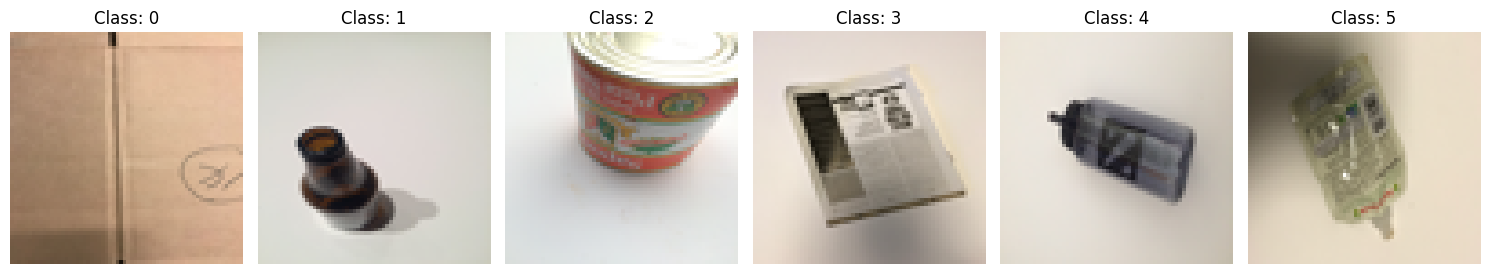

In [44]:
labels = list(set(processed_dataset['train']['label']))

fig, axes = plt.subplots(nrows=1, ncols=len(labels), figsize=(15, 5))

for i, label in enumerate(labels):
    for example in processed_dataset['train']:
      if example['label'] == label:
        image = example['image']
        break

    axes[i].imshow(image)
    axes[i].set_title(f"Class: {label}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

## 4. Model Architectures

### 4.1 Fully Connected Neural Network Model

In [47]:
def build_fc_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(64, 64, 3)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(6, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

fc_model = build_fc_model()
fc_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_5 (Flatten)                  │ (None, 12288)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 128)                 │       1,572,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,581,638 (6.03 MB)

 Trainable params: 1,581,638 (6.03 MB)

 Non-trainable params: 0 (0.00 B)

### 4.2 Convolutional Neural Network (CNN) Model

In [ ]:
def build_cnn_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(6, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

cnn_model = build_cnn_model()
cnn_model.summary()

### 4.3 Quantum Convolutional Neural Network (QCNN) Model

In [16]:
!pip install tensorflow==2.15.0 # Install a compatible version of tensorflow
!pip install cirq==1.3.0 # Install Cirq version 1.3.0 as per the issue description
!pip install -U tensorflow-quantum # Update tensorflow-quantum to the latest compatible version
!pip install sympy

In [17]:
# Import Libraries for Quantum
import tensorflow_quantum as tfq
import cirq
import sympy

In [61]:
# Define the quantum convolution layer
def quantum_conv_layer_multi_scale(qubits, circuit, params):

    # Apply RX gates
    for i in range(len(qubits)):
        circuit.append(cirq.rx(params[i])(qubits[i]))

    # Geometric progression step sizes (1, 2, 4, ...)
    num_qubits = len(qubits)
    step_sizes = [2**i for i in range(int(sympy.log(num_qubits, 2)))]

    # CX and CZ gates following the multi-scale convolution pattern
    for step in step_sizes:
        for i in range(num_qubits - step):
            # Apply CX gates
            circuit.append(cirq.CX(qubits[i], qubits[i + step]))
            # CZ gates for additional entanglement
            if step > 1:  # Only apply CZ for larger step sizes
                circuit.append(cirq.CZ(qubits[i], qubits[i + step]))

    return circuit

In [62]:
def build_qcnn_model():
    # Define the qubits
    qubits = [cirq.GridQubit(0, i) for i in range(5)]
    circuit = cirq.Circuit()

    # Quantum layer
    params = [sympy.Symbol(f'theta{i}') for i in range(len(qubits))]
    circuit = quantum_conv_layer_multi_scale(qubits, circuit, params)

    # Define the operators
    operators = [cirq.Z(q) for q in qubits]

    model = tf.keras.Sequential([
        tfq.layers.PQC(circuit, operators),
        tf.keras.layers.Dense(6, activation='softmax')  # 6 output categories
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    print(circuit)
    return model

model = build_qcnn_model()
qcnn_model.summary()

                                        ┌──┐   ┌──┐
(0, 0): ───Rx(theta0)───@───────────@────@────────────────
                        │           │    │
(0, 1): ───Rx(theta1)───X───@───────┼────┼@─────@─────────
                            │       │    ││     │
(0, 2): ───Rx(theta2)───────X───@───X────@┼─────┼@────@───
                                │         │     ││    │
(0, 3): ───Rx(theta3)───────────X───@─────X─────@┼────┼───
                                    │            │    │
(0, 4): ───Rx(theta4)───────────────X────────────X────@───
                                        └──┘   └──┘


## 5. Model Training

In [46]:
fc_history = fc_model.fit(tf_dataset_train, validation_data=tf_dataset_val, epochs=10)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.6390 - loss: 5778.4727 - val_accuracy: 0.0000e+00 - val_loss: 2524.9236
Epoch 2/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1526 - loss: 308.8814 - val_accuracy: 0.3933 - val_loss: 1.7915
Epoch 3/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0943 - loss: 1.7705 - val_accuracy: 0.0000e+00 - val_loss: 1.8031
Epoch 4/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2371 - loss: 1.7494 - val_accuracy: 0.0000e+00 - val_loss: 1.8157
Epoch 5/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2537 - loss: 1.7319 - val_accuracy: 0.0000e+00 - val_loss: 1.8294
Epoch 6/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2598 - loss: 1.7176 - val_accuracy: 0.0000e+00 - val_loss: 1.8437
Epoch 7/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2598 - loss: 1.7058 - val_accuracy: 0.0000e+00 - val_loss: 1.8582
Epoch 8/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2598 - loss: 1.6

In [50]:
cnn_history = cnn_model.fit(tf_dataset_train, validation_data=tf_dataset_val, epochs=10)

Epoch 1/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.6576 - loss: 68.3909 - val_accuracy: 0.3297 - val_loss: 1.9417
Epoch 2/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1260 - loss: 1.8538 - val_accuracy: 0.0068 - val_loss: 1.8541
Epoch 3/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4024 - loss: 3.0138 - val_accuracy: 0.0763 - val_loss: 1.8713
Epoch 4/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4089 - loss: 5.8931 - val_accuracy: 0.0245 - val_loss: 1.8736
Epoch 5/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5230 - loss: 10.6862 - val_accuracy: 0.0411 - val_loss: 1.8172
Epoch 6/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4540 - loss: 1.9660 - val_accuracy: 0.1722 - val_loss: 2.1117
Epoch 7/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5312 - loss: 7.9803 - val_accuracy: 0.3943 - val_loss: 5.8624
Epoch 8/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5303 - loss: 5.5995 - val_accuracy: